<a href="https://colab.research.google.com/github/trilgar/NN_2022/blob/master/NN_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import numpy as np
from torchvision import datasets
from tqdm import tqdm
import sys
from torchvision.transforms import RandAugment
from imgaug import augmenters as iaa

Встановлення сіду генератору

In [ ]:
torch.manual_seed(10)

Завантаження датасету OxfordIIITPet

In [ ]:
training_data = datasets.OxfordIIITPet(
    root="A:\datasets",
    download=True,
)

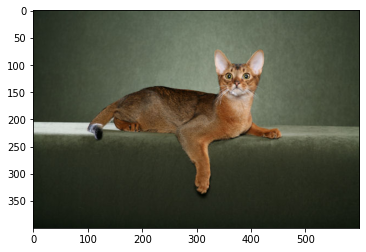

In [ ]:
plt.imshow(plt.imread('/content/A:\datasets/oxford-iiit-pet/images/Abyssinian_1.jpg'))

In [ ]:
filenames = glob('/content/A:\datasets/oxford-iiit-pet/images/*.jpg')

In [ ]:
img = Image.open('/content/A:\datasets/oxford-iiit-pet/images/Abyssinian_1.jpg').convert('RGB')
img = np.array(img).astype(np.uint8)

In [ ]:
rand_aug = iaa.RandAugment(n=3, m=7)

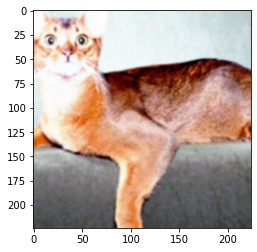

In [ ]:
plt.imshow(vgg_format(rand_aug(images=[img])[0]).permute(1,2,0).numpy())

# Supervised learning model

In [ ]:
class PetDataSet(Dataset):

    def __init__(self, filenames, class_to_label, transforms=None):
        self.filenames = filenames
        self.transforms = transforms
        self.class_to_label = class_to_label

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        # img = plt.imread(filename)
        # img = Image.fromarray(img).convert('RGB')
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)

        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img ,label

    def get_label_from_filename(self, filename):
        clazz =  filename.rsplit('/', 1)[1].rsplit('_', 1)[0].replace('_', ' ').title()
        return self.class_to_label[clazz]

In [ ]:
vgg_format = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

In [ ]:
dataset=PetDataSet(filenames,training_data.class_to_idx,vgg_format)

train_ds_length = int(0.8 * len(dataset))
test_ds_length = int(0.2 * len(dataset))

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_ds_length, test_ds_length])

train_dl = DataLoader(train_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

Модель

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
load_from_existing = False

In [ ]:
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('best_vgg.mdl'))
    print('loaded from previous save !!!')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Навчання моделі

In [ ]:
cross_el = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
epochs = 10

In [ ]:
def evalute(model, loader):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        x.cpu()
        y.cpu()
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total

In [ ]:
best_acc, best_epoch = 0, 0
losses = []
accuracy = []
for epoch in range(epochs):
    epoch_losses=0
    iters = 0
    model.train()
    train_bar = tqdm(train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss.item())
        x.cpu()
        y.cpu()
    losses.append(epoch_losses/iters)
    torch.cuda.empty_cache()
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, test_dl)
        accuracy.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_vgg.mdl')

100%|██████████| 93/93 [00:17<00:00,  5.44it/s]
val_acc =  0.8301759133964818
100%|██████████| 93/93 [00:17<00:00,  5.45it/s]
val_acc =  0.851150202976996
100%|██████████| 93/93 [00:17<00:00,  5.44it/s]
val_acc =  0.8308525033829499
100%|██████████| 93/93 [00:17<00:00,  5.43it/s]
val_acc =  0.8335588633288228
100%|██████████| 93/93 [00:17<00:00,  5.40it/s]
val_acc =  0.8389715832205683
100%|██████████| 93/93 [00:17<00:00,  5.40it/s]
val_acc =  0.8599458728010826
100%|██████████| 93/93 [00:17<00:00,  5.35it/s]
val_acc =  0.8207036535859269
100%|██████████| 93/93 [00:17<00:00,  5.26it/s]
val_acc =  0.8024357239512855
100%|██████████| 93/93 [00:17<00:00,  5.39it/s]
val_acc =  0.8667117726657646
100%|██████████| 93/93 [00:17<00:00,  5.46it/s]
val_acc =  0.8802435723951285


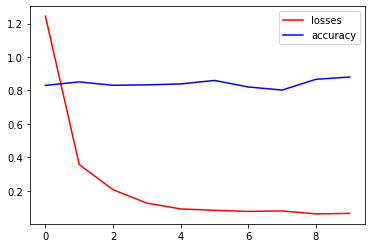

In [ ]:
plt.plot(losses, label='losses',color='red')
plt.plot(accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_vgg.mdl'))
print('loaded from ckpt!')

test_acc = evalute(model, test_dl)
print('test acc:', test_acc)

loaded from ckpt!
100%|██████████| 93/93 [00:17<00:00,  5.45it/s]
test acc: 0.8802435723951285


# Noisy Student learning

Спочатку навчимо модель для розмітки нерозмічених даних

In [ ]:
torch.cuda.empty_cache()
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('lab2_supervised.mdl'))
    print('loaded from previous save !!!')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
m_train_ds_length = int(0.3 * len(train_ds))
u_train_ds_length = int(0.7 * len(train_ds))

marked_train_ds, unmarked_train_ds = torch.utils.data.random_split(train_ds, [m_train_ds_length+1, u_train_ds_length])

marked_train_dl = DataLoader(marked_train_ds, batch_size=16)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

Навчання моделі на розмічених даних

In [ ]:
best_acc, best_epoch = 0, 0
losses_semisupervised = []
accuracy_semisupervised = []
for epoch in range(epochs):
    epoch_losses=0
    iters = 0
    model.train()
    train_bar = tqdm(marked_train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] (marked_dataset) loss:{:.3f}".format(epoch + 1, epochs, loss.item())
    losses_semisupervised.append(epoch_losses/iters)
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, test_dl)
        accuracy_semisupervised.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'lab2_supervised.mdl')

100%|██████████| 93/93 [00:17<00:00,  5.45it/s]
val_acc =  0.6691474966170501
100%|██████████| 93/93 [00:16<00:00,  5.48it/s]
val_acc =  0.7530446549391069
100%|██████████| 93/93 [00:16<00:00,  5.49it/s]
val_acc =  0.7611637347767253
100%|██████████| 93/93 [00:16<00:00,  5.48it/s]
val_acc =  0.7990527740189445
100%|██████████| 93/93 [00:17<00:00,  5.43it/s]
val_acc =  0.7266576454668471
100%|██████████| 93/93 [00:17<00:00,  5.46it/s]
val_acc =  0.7726657645466847
100%|██████████| 93/93 [00:17<00:00,  5.43it/s]
val_acc =  0.7679296346414073
100%|██████████| 93/93 [00:17<00:00,  5.46it/s]
val_acc =  0.7774018944519621
100%|██████████| 93/93 [00:17<00:00,  5.45it/s]
val_acc =  0.8010825439783491
100%|██████████| 93/93 [00:16<00:00,  5.49it/s]
val_acc =  0.7638700947225981


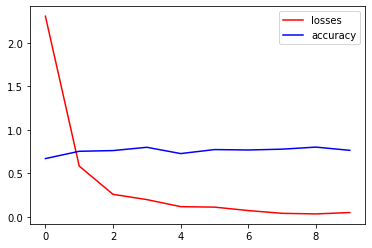

In [ ]:
plt.plot(losses_semisupervised, label='losses',color='red')
plt.plot(accuracy_semisupervised, label= 'accuracy', color='blue')
plt.legend()
plt.show()

Навчання за допомогою NoisyStudent на повній вибірці (розмічені дані + псевдорозмічені)

In [ ]:
class PseudoLabeledPetDataSet(PetDataSet):

    def __init__(self, filenames, model = None, augment = None, transforms=None):
        super(PseudoLabeledPetDataSet, self).__init__(filenames, None, transforms=transforms)
        self.augment = augment
        self.model = model
        if self.model is not None:
            self.pseudolabels = self.calculate_pseudolabels()

    @staticmethod
    def from_ss(ds: Subset, model, augment=None, transforms = None):
        return PseudoLabeledPetDataSet(ds.dataset.dataset.filenames, model, augment = augment, transforms = transforms)

    def __getitem__(self, i):
        filename = self.filenames[i]
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)
        if self.augment is not None:
            img = self.augment(images=[img])
            img = np.array(img[0]).astype(np.uint8)
        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img ,label

    def calculate_pseudolabels(self):
        pseudolabels = {}
        self.model.eval()
        filenames = self.filenames
        for filename in tqdm(filenames):
            img = Image.open(filename).convert('RGB')
            img = np.array(img).astype(np.uint8)
            if self.transforms is not None:
                img = self.transforms(img)
            logit = self.model(img.to(device).unsqueeze(0))
            predict = logit.argmax(dim=1)
            pseudolabels[filename] = predict.item()
        return pseudolabels

    def get_label_from_filename(self, filename):
        if self.model is not None:
            return self.pseudolabels[filename]
        else:
            return PetDataSet.get_label_from_filename(self, filename)

In [ ]:
# _marked_train_ds = PseudoLabeledPetDataSet.from_ss(marked_train_ds, None, augment=RandAugment(), transforms=vgg_format)
# marked_train_dl = DataLoader(_marked_train_ds, batch_size=16)
rand_aug = iaa.RandAugment(n=2, m=9)
_unmarked_train_ds = PseudoLabeledPetDataSet.from_ss(unmarked_train_ds, model, augment=rand_aug, transforms=vgg_format)
unmarked_train_dl = DataLoader(_unmarked_train_ds, batch_size=8)

marked_train_dl = DataLoader(marked_train_ds, batch_size=8)

100%|██████████| 7390/7390 [01:58<00:00, 62.40it/s]


In [ ]:
torch.cuda.empty_cache()

model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('lab2_semisupervised.mdl'))
    print('loaded from previous save !!!')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_acc, best_epoch = 0, 0
losses_semisupervised = []
accuracy_semisupervised = []
for epoch in range(epochs):
    epoch_losses=0
    iters = 0
    model.train()
    train_bar = tqdm(unmarked_train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] (unmarked_dataset) loss:{:.3f}".format(epoch + 1, epochs, loss.item())
    train_bar = tqdm(marked_train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] (marked_dataset) loss:{:.3f}".format(epoch + 1, epochs, loss.item())

    losses_semisupervised.append(epoch_losses/iters)
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, test_dl)
        accuracy_semisupervised.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'lab2_semisupervised.mdl')

100%|██████████| 93/93 [00:18<00:00,  5.03it/s]
val_acc =  0.8362652232746955
100%|██████████| 93/93 [00:17<00:00,  5.23it/s]
val_acc =  0.8179972936400541
100%|██████████| 93/93 [00:17<00:00,  5.33it/s]
val_acc =  0.8207036535859269
100%|██████████| 93/93 [00:18<00:00,  5.05it/s]
val_acc =  0.8207036535859269
100%|██████████| 93/93 [00:17<00:00,  5.30it/s]
val_acc =  0.8166441136671178
100%|██████████| 93/93 [00:17<00:00,  5.41it/s]
val_acc =  0.8112313937753721
100%|██████████| 93/93 [00:18<00:00,  5.06it/s]
val_acc =  0.8044654939106901
100%|██████████| 93/93 [00:17<00:00,  5.34it/s]
val_acc =  0.8051420838971584
100%|██████████| 93/93 [00:17<00:00,  5.32it/s]
val_acc =  0.7983761840324763
100%|██████████| 93/93 [00:17<00:00,  5.26it/s]
val_acc =  0.7889039242219216


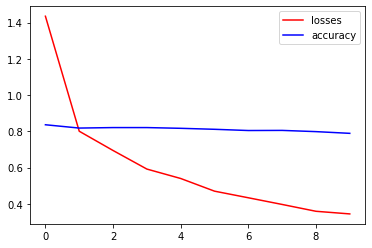

In [ ]:
plt.plot(losses_semisupervised, label='losses',color='red')
plt.plot(accuracy_semisupervised, label= 'accuracy', color='blue')
plt.legend()
plt.show()

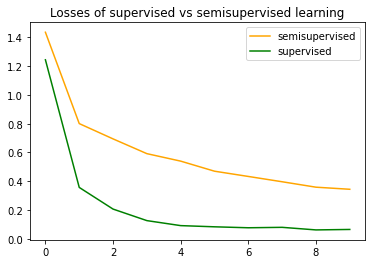

In [ ]:
plt.plot(losses_semisupervised, label='semisupervised',color='orange')
plt.plot(losses, label='supervised',color='green')
plt.title('Losses of supervised vs semisupervised learning')
plt.legend()
plt.show()

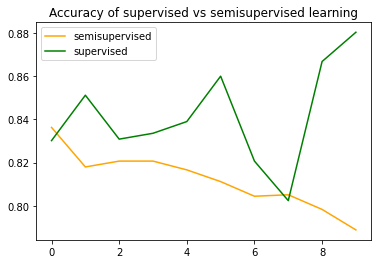

In [ ]:
plt.plot(accuracy_semisupervised, label='semisupervised',color='orange')
plt.plot(accuracy, label='supervised',color='green')
plt.title('Accuracy of supervised vs semisupervised learning')
plt.legend()
plt.show()